Chương trình thử nghiệm nhận dạng hai ảnh vân tay code bằng Python3.

In [4]:
import cv2
import os
import sys
import numpy
import matplotlib.pyplot as plt
from enhance import image_enhance
from skimage.morphology import skeletonize, thin


Load hai ảnh sẵn có trong folder database và chuyển thành ảnh xám. Có thể thử nghiệm với 4 file ảnh trong dataset FVC2000 101_1.tif, 101_2.tif, 102_1.tif, 102_2.tif

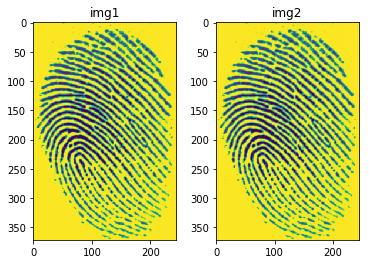

In [5]:
img1 = cv2.imread("database/101_1.tif", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("database/102_2.tif", cv2.IMREAD_GRAYSCALE)

#img1,img2 khi load bằng CV2 có kiểu dữ liệu là ndarray của numpy
f,(ax1,ax2)=plt.subplots(1,2)
ax1.imshow(img1)
ax1.set_title('img1')

ax2.imshow(img1)
ax2.set_title('img2')
plt.show()

Lấy đặc trưng


In [10]:
kp1, des1 = get_descriptors(img1)
des1

array([[  2,   2,   0, ...,   6,  16,  64],
       [  6,   2,   0, ...,   6,  16,  64],
       [  6,   0,   0, ...,  36,  16,  66],
       ..., 
       [ 66,   6, 133, ...,   0, 132,   0],
       [  2,   2, 131, ..., 128, 148,  32],
       [  0,   0,  72, ...,   0,   8,   0]], dtype=uint8)

**********Hàm lấy đặc trưng**************
*Input: ảnh (img)
*Output: điểm đặc trưng.
*************************************
Hàm này thực hiện các công việc sau:
- Cân bằng bằng cách tạo ra đối tượng CLAHE dùng opencv.
- Cải thiện chất lượng ảnh bằng hàm enhance.
- Định ngưỡng bằng threshold của opencv.
- Tạo xương (thinning)  bằng skeletonize.
- Loại bỏ các điểm nhiễu bằng hàm removedot.
- Tìm các góc bằng phương pháp Harris (link: https://en.wikipedia.org/wiki/Harris_Corner_Detector).
- Chuẩn hóa các góc Harris bằng hàm normalize của opencv.
- Chọn các góc Harris nào có giá trị lớn hơn ngưỡng Harris_threshold.
- Tính các điểm tương đồng bằng hàm ORB (dùng phương pháp ORB- link: http://ieeexplore.ieee.org.dbonline.cesti.gov.vn/document/6126544/ )của opencv.




In [7]:
def get_descriptors(img):

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    img = image_enhance.image_enhance(img)
    img = numpy.array(img, dtype=numpy.uint8)

    # Threshold
    ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU);
    # Normalize to 0 and 1 range
    img[img == 255] = 1
    
    #Thinning
    skeleton = skeletonize(img)
    skeleton = numpy.array(skeleton, dtype=numpy.uint8)
    skeleton = removedot(skeleton)
    
    # Harris corners
    harris_corners = cv2.cornerHarris(img, 3, 3, 0.04)
    harris_normalized = cv2.normalize(harris_corners, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)
    threshold_harris = 125;
    
    # Extract keypoints
    keypoints = []
    for x in range(0, harris_normalized.shape[0]):
        for y in range(0, harris_normalized.shape[1]):
            if harris_normalized[x][y] > threshold_harris:
                keypoints.append(cv2.KeyPoint(y, x, 1))
    # Define descriptor
    orb = cv2.ORB_create()
    # Compute descriptors
    _, des = orb.compute(img, keypoints)

    return (keypoints, des);

Xây dựng hàm removedot

In [9]:
def removedot(invertThin):
    temp0 = numpy.array(invertThin[:])
    temp0 = numpy.array(temp0)
    temp1 = temp0/255
    temp2 = numpy.array(temp1)
    temp3 = numpy.array(temp2)
    
    enhanced_img = numpy.array(temp0)
    filter0 = numpy.zeros((10,10))
    W,H = temp0.shape[:2]
    filtersize = 6
    
    for i in range(W - filtersize):
        for j in range(H - filtersize):
            filter0 = temp1[i:i + filtersize,j:j + filtersize]

            flag = 0
            if sum(filter0[:,0]) == 0:
                flag +=1
            if sum(filter0[:,filtersize - 1]) == 0:
                flag +=1
            if sum(filter0[0,:]) == 0:
                flag +=1
            if sum(filter0[filtersize - 1,:]) == 0:
                flag +=1
            if flag > 3:
                temp2[i:i + filtersize, j:j + filtersize] = numpy.zeros((filtersize, filtersize))
    return temp2